In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import fill
import numpy as np
import pandas as pd
import scanpy.external as sce
import scanpy as sc
import anndata as an
from scipy.spatial.distance import cdist
import scvelo as scv
# import gget
import re
# import rapids_singlecell as rsc
from scipy.stats import linregress
from sklearn.preprocessing import MinMaxScaler
# import cellrank as cr

sc.settings.verbosity = 3 

print(scv.__version__)

0.3.3


In [2]:
import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger('py.warnings').setLevel(logging.ERROR)

# Load expression

In [3]:
%%time
# fpath = "/nfs/turbo/umms-indikar/shared/projects/HSC/pipeline_outputs/integrated_anndata/pseudotime.h5ad"
fpath = "/scratch/indikar_root/indikar1/jrcwycy/hsc_temp/scvelo.h5ad"
adata = sc.read_h5ad(fpath)
adata.X = adata.layers['log_norm'].copy()
adata

CPU times: user 575 ms, sys: 8.23 s, total: 8.81 s
Wall time: 1min 10s


AnnData object with n_obs × n_vars = 15867 × 21412
    obs: 'batch', 'phase', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'n_genes', 'n_reads', 'raw_clusters', 'bbknn_clusters', 'harmony_clusters', 'cluster_str', 'barcoded_phase', 'S_score', 'G2M_score', 'dpt_pseudotime', 'dpt_groups', 'dpt_order', 'dpt_order_indices', 'G1_pseudotime', 'G1_order', 'G2M_pseudotime', 'G2M_order', 'mean_pseudotime', 'mean_order', 'nnz', 'velocyto_cell_id', 'cell_id', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'velocity_self_transition', 'velocity_pseudotime', 'G1_velocity_pseudotime', 'G2M_velocity_pseudotime', 'mean_veloci

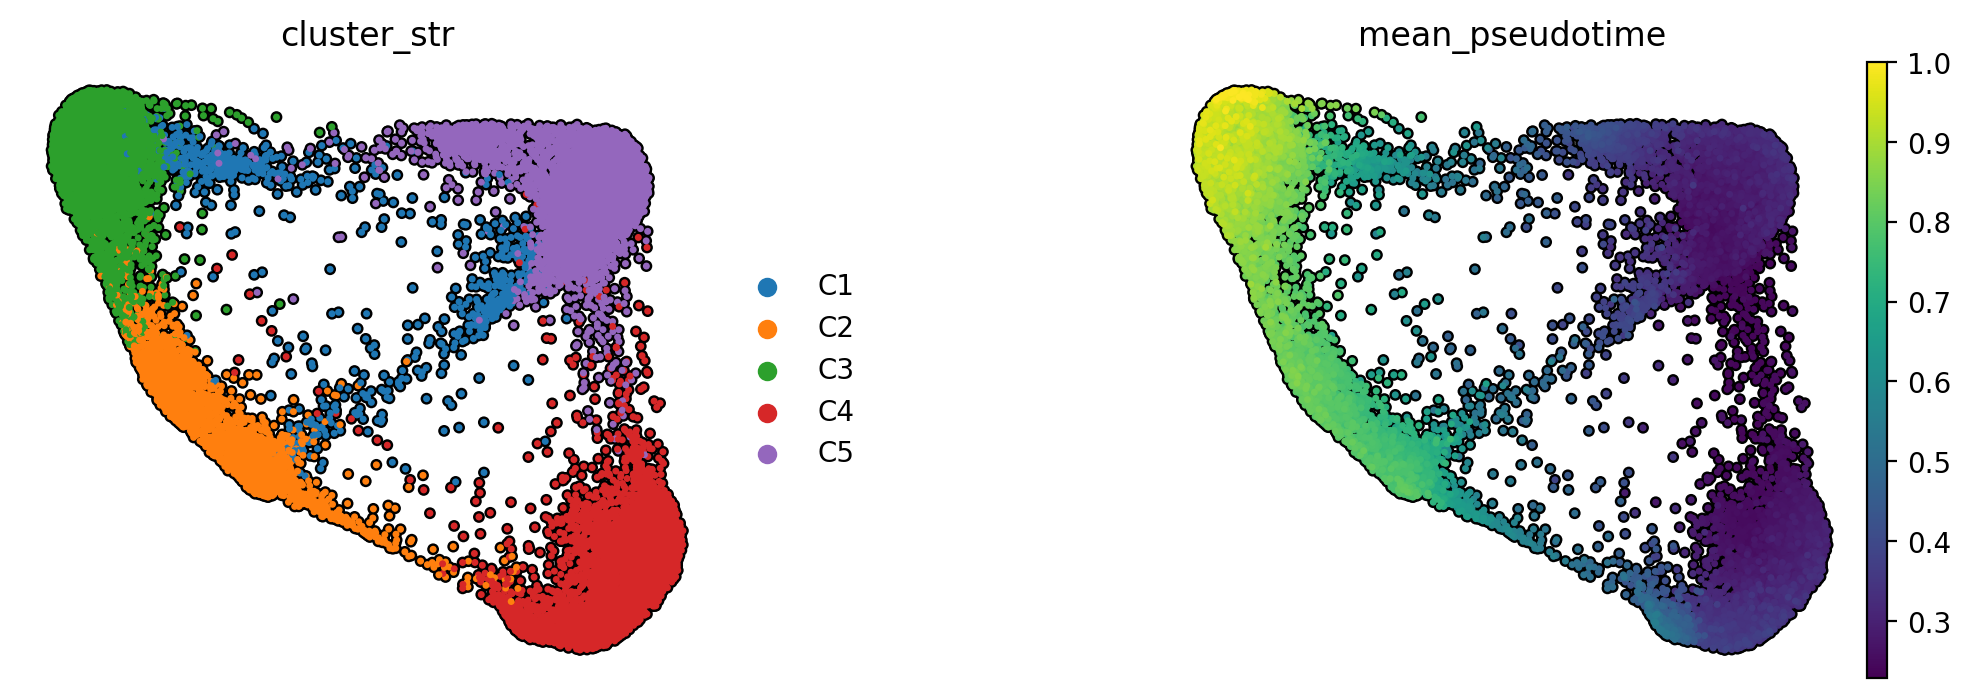

In [6]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

sc.pl.draw_graph(
    adata, 
    color=['cluster_str', 'mean_pseudotime'],
    size=25,
    ncols=3,
    alpha=1,
    use_raw=False,
    add_outline=True,
    outline_color=('k', 'k'),
    frameon=False,
    wspace=0.5,
)

# Load velocity

In [4]:
%%time

fpaths = {
    "hsc" : "/scratch/indikar_root/indikar1/shared_data/hsc_velocyto/merged_NKUVW.loom",
    "fib" : "/scratch/indikar_root/indikar1/shared_data/fib_velocyto/merged_PW6SH.loom",
}

ldatas = []
for key, fpath in fpaths.items():
    print(f"Working {key}...")

    ldata = sc.read_loom(fpath)
    ldata.var_names_make_unique()

    # set the cell-ids back to barcodes
    ldata.obs['velocyto_cell_id'] = ldata.obs_names.copy()
    ldata.obs['cell_id'] = ldata.obs['velocyto_cell_id'].apply(lambda x: x.split(":")[1][:-1] + "-1")
    ldata.obs_names = ldata.obs['cell_id'].values

    # Print initial cell counts
    print(f"\tInitial cell count in ldata: {ldata.shape[0]}")
    print(f"\tInitial cell count in adata: {adata.shape[0]}")
    
    # IDs not retained in ldata
    removed_from_ldata = ldata.obs.index[~ldata.obs.index.isin(adata.obs_names)].tolist()
    
    # IDs not retained in adata
    removed_from_adata = adata.obs.index[~adata.obs.index.isin(ldata.obs_names)].tolist()
    
    # Filter ldata to keep only cells present in adata
    initial_ldata_count = ldata.shape[0]
    ldata = ldata[ldata.obs.index.isin(adata.obs_names), :].copy()
    print(f"\tFiltered ldata: {ldata.shape[0]} cells kept, {initial_ldata_count - ldata.shape[0]} cells removed")

    ldatas.append(ldata)

    
ldata = an.concat(ldatas)   
ldata

Working hsc...
	Initial cell count in ldata: 11933
	Initial cell count in adata: 15867
	Filtered ldata: 8326 cells kept, 3607 cells removed
Working fib...
	Initial cell count in ldata: 8963
	Initial cell count in adata: 15867
	Filtered ldata: 7541 cells kept, 1422 cells removed
CPU times: user 55.5 s, sys: 20.2 s, total: 1min 15s
Wall time: 1min 19s


AnnData object with n_obs × n_vars = 15867 × 38606
    obs: 'velocyto_cell_id', 'cell_id'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

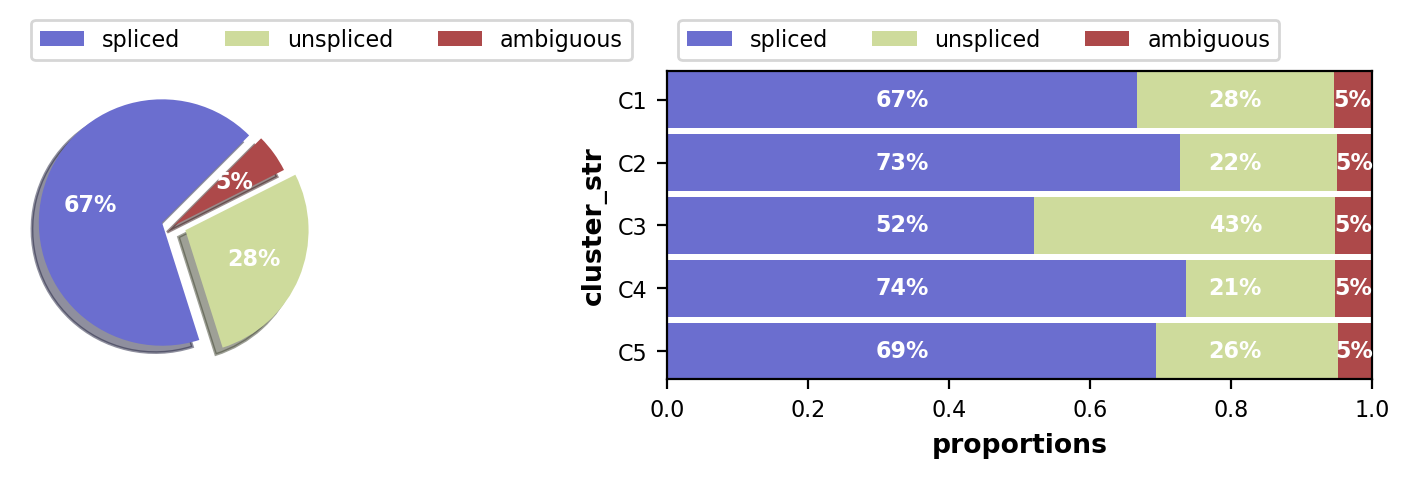

AnnData object with n_obs × n_vars = 15867 × 21412
    obs: 'batch', 'phase', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'n_genes', 'n_reads', 'raw_clusters', 'bbknn_clusters', 'harmony_clusters', 'cluster_str', 'barcoded_phase', 'S_score', 'G2M_score', 'dpt_pseudotime', 'dpt_groups', 'dpt_order', 'dpt_order_indices', 'G1_pseudotime', 'G1_order', 'G2M_pseudotime', 'G2M_order', 'mean_pseudotime', 'mean_order', 'nnz', 'velocyto_cell_id', 'cell_id', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total

In [5]:
adata = scv.utils.merge(adata, ldata)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 7, 5

scv.pl.proportions(adata, groupby='cluster_str', dpi=200)

adata

In [6]:
%%time
sc.pp.neighbors(adata, n_neighbors=150, use_rep='X_pca_harmony')
scv.pp.moments(adata, use_rep='X_pca_harmony')

scv.tl.recover_dynamics(adata, n_jobs=8) 

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:00)
Normalized count data: spliced, unspliced.
computing moments based on connectivities
    finished (0:00:17) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 8/40 cores)
or disable the progress bar using `show_progress_bar=False`.


/nfs/turbo/umms-indikar/Jillian/conda-envs/scvelo/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=3980369) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


    finished (0:11:11) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
CPU times: user 2min 47s, sys: 56.7 s, total: 3min 43s
Wall time: 12min 34s


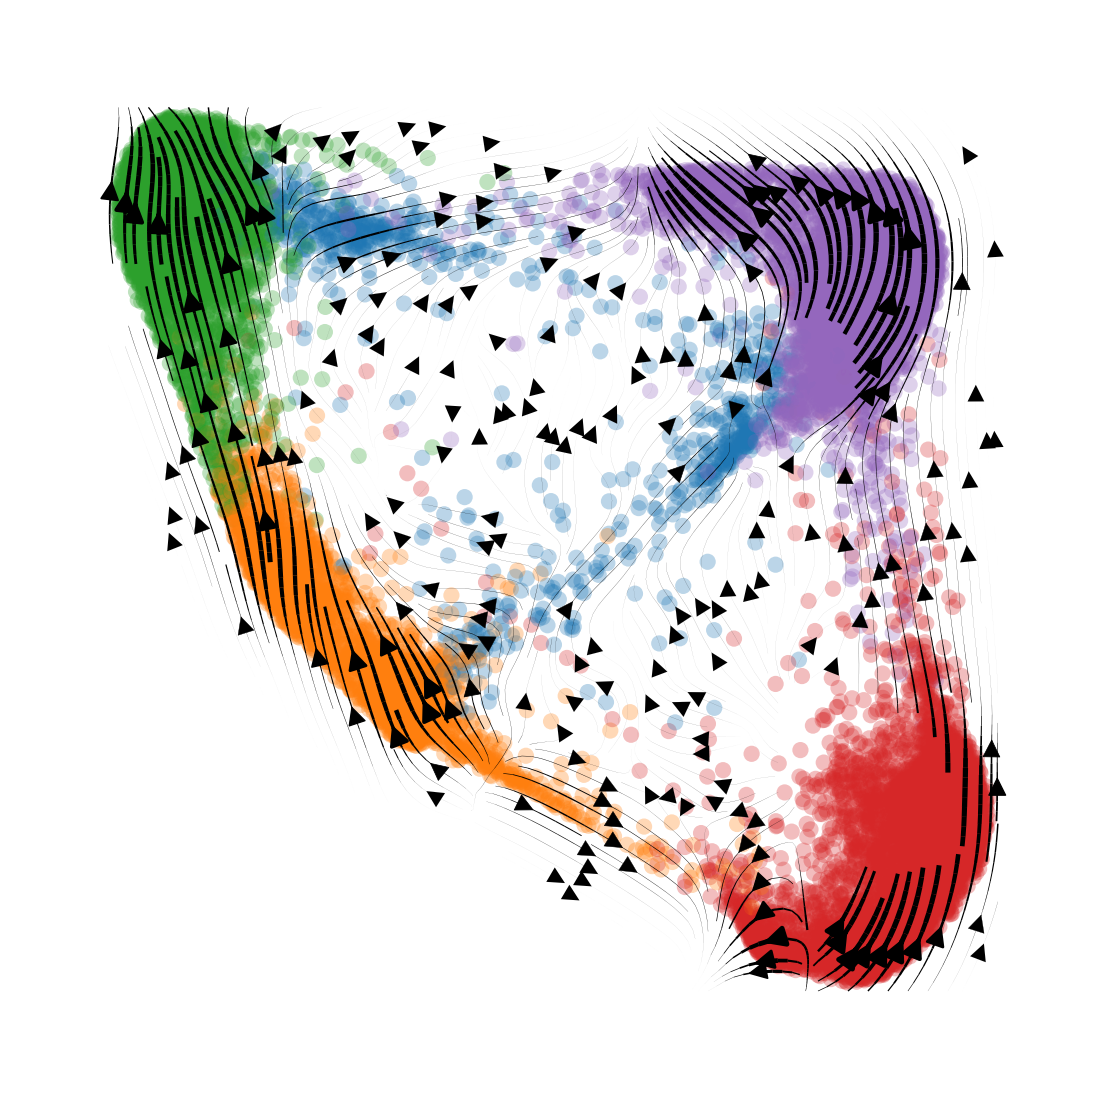

CPU times: user 3.26 s, sys: 74.2 ms, total: 3.33 s
Wall time: 3.38 s


In [12]:
%%time
# # scv.tl.velocity(adata, mode='dynamical')
# scv.tl.velocity(adata)

# scv.tl.velocity_graph(
#     adata, 
#     n_jobs=8,
#     basis='X_pca_harmony',
#     n_neighbors=150,
# )

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4.5, 4.5

scv.pl.velocity_embedding_stream(
    adata, 
    density=(3, 3),
    basis='X_draw_graph_fa',
    color='cluster_str',
    smooth=True,
    title="",
    legend_loc='none',
    # legend_loc='right_margin',
    linewidth=0.75,
    arrow_size=1,
    add_margin=0.1,
)

G1: root_id='ACTCAATAGTGCTGTA-1' root_key=9300
G2M: root_id='GTCCATAAGGGGATAT-1' root_key=13940


/nfs/turbo/umms-indikar/Jillian/conda-envs/scvelo/lib/python3.13/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/nfs/turbo/umms-indikar/Jillian/conda-envs/scvelo/lib/python3.13/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/nfs/turbo/umms-indikar/Jillian/conda-envs/scvelo/lib/python3.13/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/nfs/turbo/um

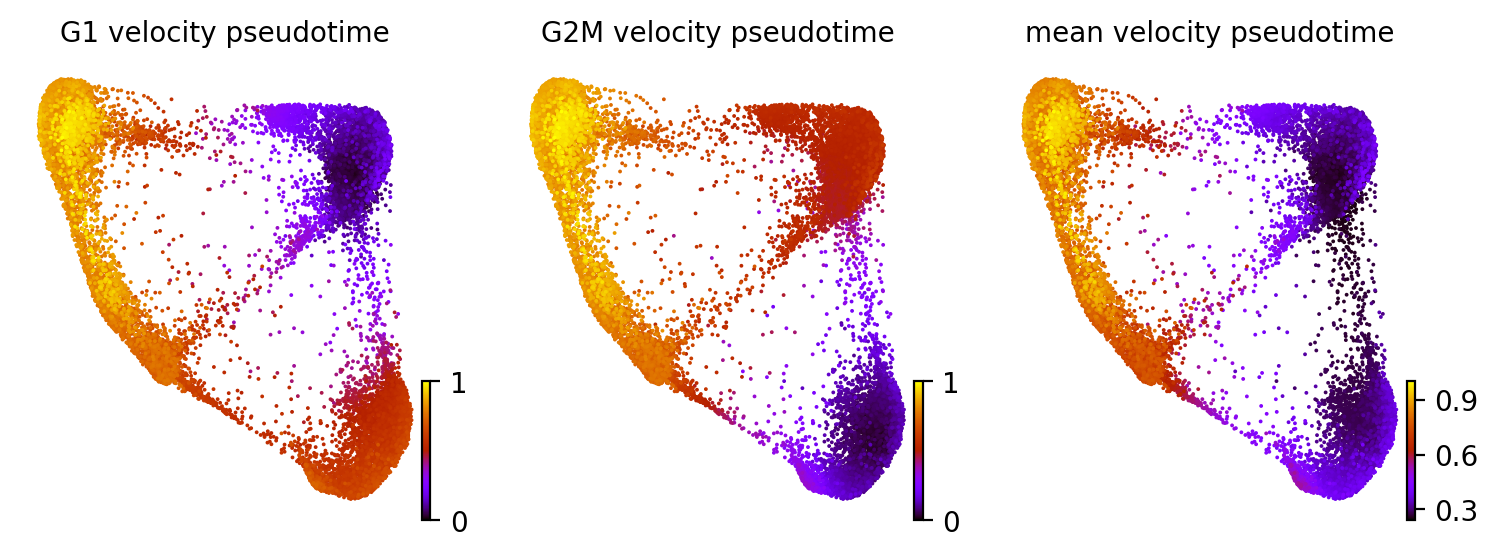

CPU times: user 21.5 s, sys: 19.5 s, total: 41 s
Wall time: 33.8 s


In [9]:
%%time
def find_closest_cell(adata, obs_key='barcoded_phase', value='G1', obsm_key='X_pca'):
    """
    Find the cell closest to a median vector in PCA space.

    Parameters:
        adata (AnnData): Annotated data matrix.
        obs_key (str): Key in adata.obs indicating group
        value (str): The value for aggregation 
        obsm_key (str): Key in adata.obsm for PCA or other embedding.

    Returns:
        tuple: (cell_id (str), index (int)) of the closest G1 cell in adata.obs_names
    """
    mask = adata.obs[obs_key] == value
    emb = adata.obsm[obsm_key][mask]

    median_vec = np.median(emb, axis=0)
    dists = cdist(emb, median_vec.reshape(1, -1)).flatten()
    closest_idx = np.argmin(dists)

    cell_id = adata.obs_names[mask][closest_idx]
    cell_index = np.where(adata.obs_names == cell_id)[0][0]

    return cell_id, cell_index

# loop through initial state
for phase, cluster in zip(['G1', 'G2M'], ['C5', 'C4']):
    root_id, root_key = find_closest_cell(
        adata,
        obs_key='cluster_str',
        value=cluster,
    )

    print(f"{phase}: {root_id=} {root_key=}")

    scv.tl.velocity_pseudotime(adata, root_key=root_key)
    adata.obs[f'{phase}_velocity_pseudotime'] = adata.obs['velocity_pseudotime']


adata.obs['mean_velocity_pseudotime'] = adata.obs[['G1_velocity_pseudotime', 'G2M_velocity_pseudotime']].mean(axis=1)


plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3

scv.pl.scatter(
    adata, 
    color=['G1_velocity_pseudotime', 'G2M_velocity_pseudotime', 'mean_velocity_pseudotime'],
    basis='X_draw_graph_fa',
    cmap='gnuplot',
)

In [6]:
adata

AnnData object with n_obs × n_vars = 15867 × 21412
    obs: 'batch', 'phase', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'n_genes', 'n_reads', 'raw_clusters', 'bbknn_clusters', 'harmony_clusters', 'cluster_str', 'barcoded_phase', 'S_score', 'G2M_score', 'dpt_pseudotime', 'dpt_groups', 'dpt_order', 'dpt_order_indices', 'G1_pseudotime', 'G1_order', 'G2M_pseudotime', 'G2M_order', 'mean_pseudotime', 'mean_order', 'nnz', 'velocyto_cell_id', 'cell_id', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'velocity_self_transition', 'velocity_pseudotime', 'G1_velocity_pseudotime', 'G2M_velocity_pseudotime', 'mean_veloci

In [4]:
adata.uns['cluster_str_colors_old'] = adata.uns['cluster_str_colors'].copy()

adata.uns['cluster_str_colors'] = ['#FCAE91', '#FB6A4A', '#CB181D', '#808080', '#808080']

adata.uns['cluster_str_colors']

['#FCAE91', '#FB6A4A', '#CB181D', '#808080', '#808080']

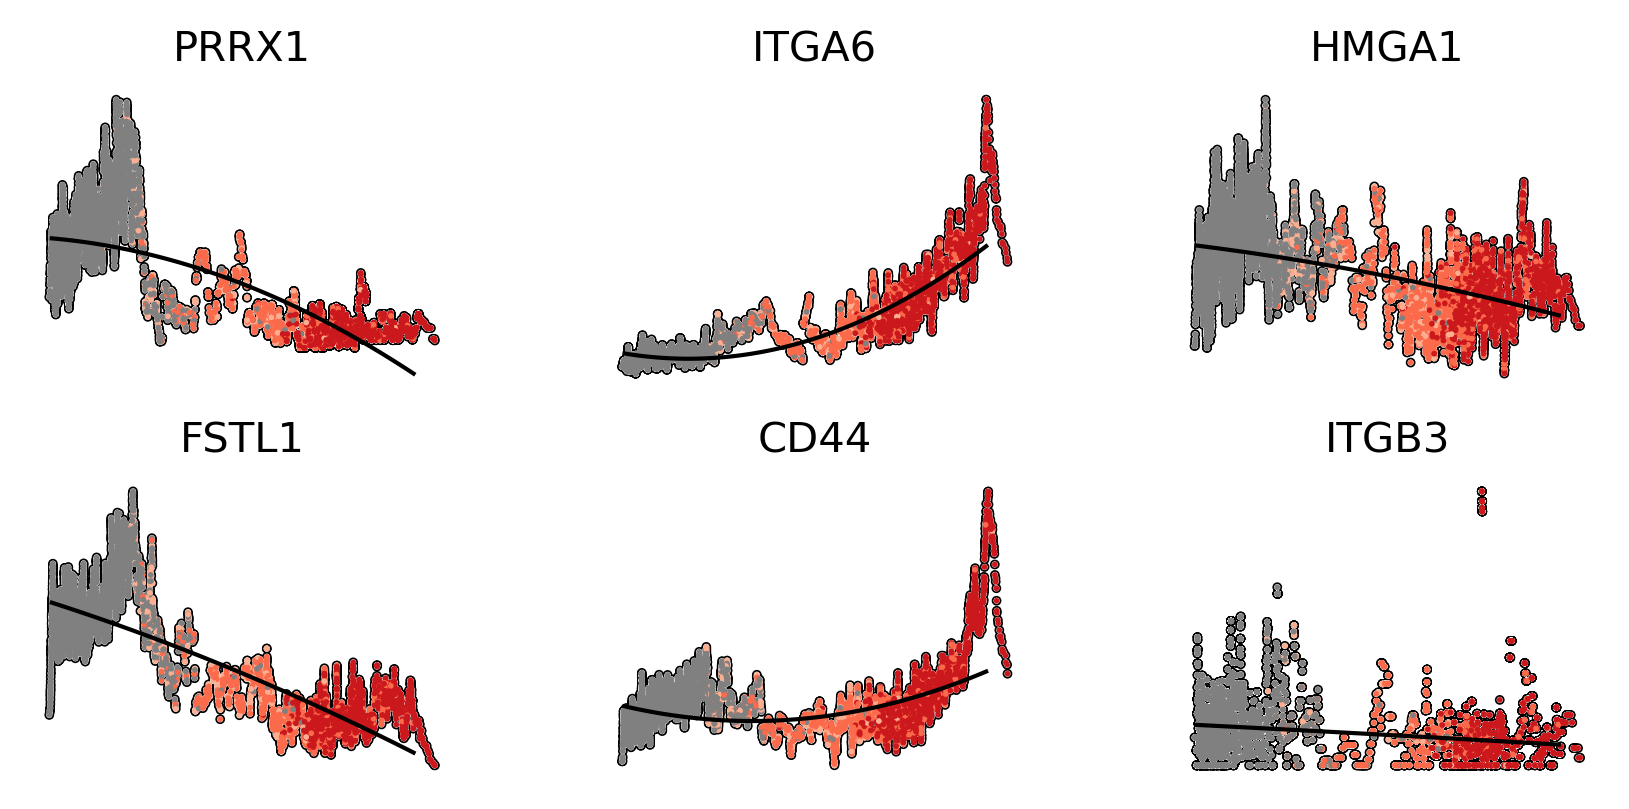

In [16]:
# var_names = ['CD34', 'ACE', 'ITGA6', 'HMGB1', 'CSNK2B', 'MYLK']

# var_names = ['CD34', 'ACE', 'ITGA6', 'HMGB1', 'CSNK2B', 'MYLK', 'LMO2', 'SCL', 'ETV2', 'RUNX1', 'GATA2', 'GFI1', 'SPI1', 'CD44',
            #  'GFI1B', 'TWIST1', 'TWIST2', 'MYB', 'SNAI1', 'SNAI2', 'EZH1', 'EZH2', 'SMAD3', 'RBFOX2',
            # ]

var_names = [
    
#     'PRRX1', 'FSTL1', 'COL1A2',
    
#     # 'DCN', 'PRRX1', 'COL1A2', 'SRF', 'FBNL2', 'LUM', 'FSTL1',
#     'ITGA6', 'ETV2', 'CD44', # EHT-related
    # 'RBFOX2', 'SMAD3', 'HMGB1', # splicing, stemness maintenance, chromatin remodeling
    
    # 'CD34', 'RUNX1', 'TGFB1', 'HMGA1', 'HMGA2', 'IGF2BP2', 'ITGB3', 'SCA1', 'TGFBI', 'ITGAM', 'PROCR',
    
    'PRRX1', 'ITGA6', 'HMGA1',
    'FSTL1', 'CD44', 'ITGB3',
]
    


var_names = [g for g in var_names if g in adata.var_names]

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 2.25, 1.5

scv.pl.scatter(
    adata, 
    x='mean_velocity_pseudotime', 
    y=var_names, 
    add_polyfit=True,
    ncols=3,
    normalize_data=True,
    add_outline=True,
    frameon=False,
    n_convolve=50,
    smooth=True,
    color='cluster_str',
    wspace=0.35,
)

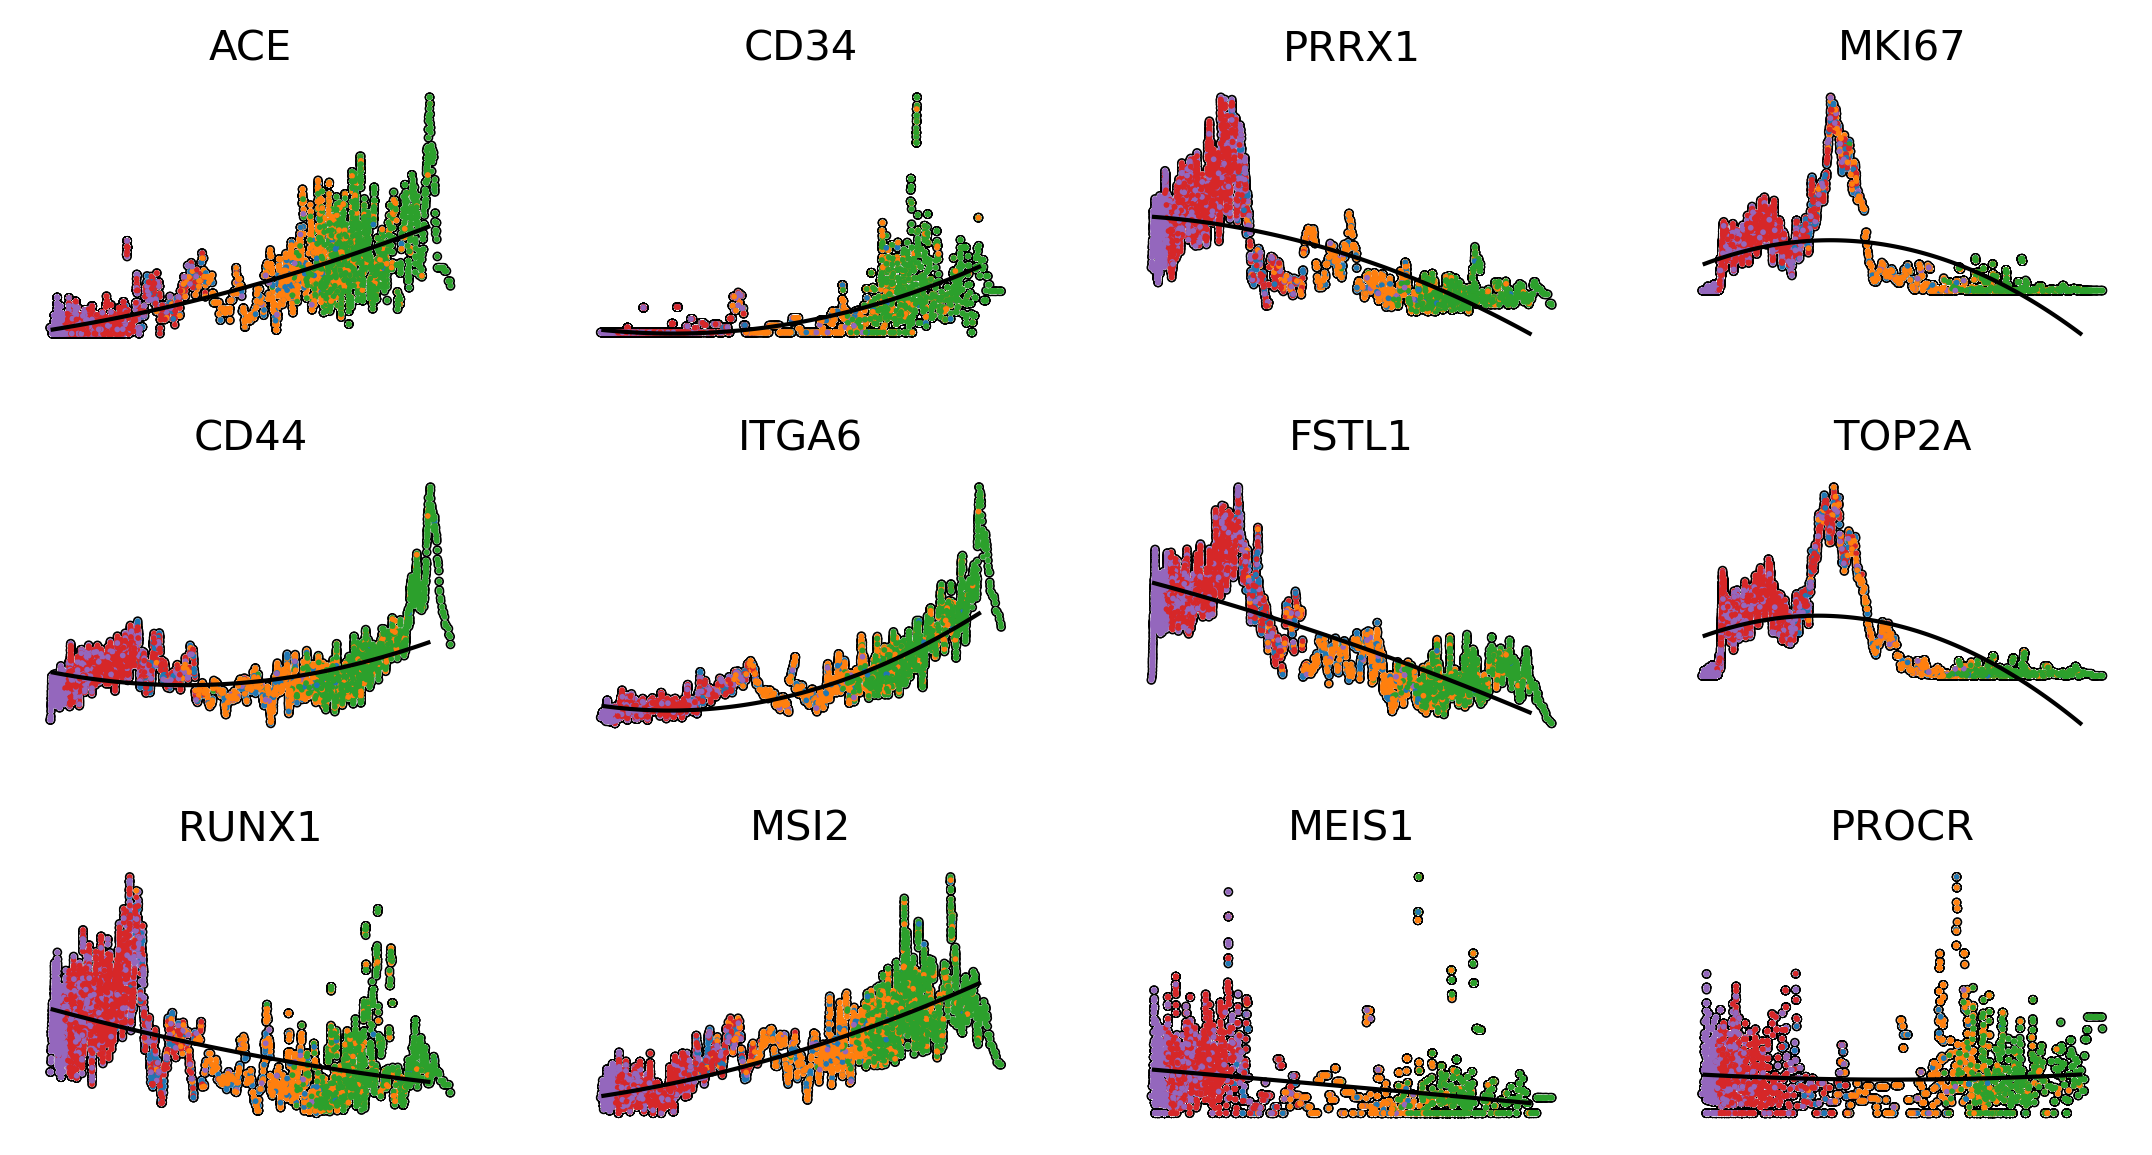

In [50]:
var_names = [
    # 'CD34', 'ACE', 'ITGA6',
    # 'CD44', 
    # 'PCNA', 'PLK1',
    
    # 'MKI67', 'PRRX1', 'ACE', 'CD34', #'MEIS1', #'MSI2',
    # 'TOP2A', 'FSTL1', 'CD44', 'ITGA6', #'PROCR', 
    
    # 'RUNX1', 'MSI2', 'MEIS1', 'PROCR',

    
    'ACE', 'CD34', 'PRRX1', 'MKI67',
    'CD44', 'ITGA6', 'FSTL1', 'TOP2A',
    'RUNX1', 'MSI2', 'MEIS1', 'PROCR',
    
    
    # 'MEIS1', 'HOPX', 'MECOM', 'BMI1', 'MLLT3', 'PROM1', 'PROCR', 'RUNX1', 'MSI2', 'SPI1', 'SOX17', 'CD164', 'GATA1', 
    # 'CD164', 'HLF', 'IGF2BP1', 'HES1', 'LMO2', 'ERG', 'ESAM',
    
]

var_names = [g for g in var_names if g in adata.var_names]

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 2.25, 1.5

scv.pl.scatter(
    adata, 
    x='mean_velocity_pseudotime', 
    y=var_names, 
    add_polyfit=True,
    ncols=4,
    normalize_data=True,
    add_outline=True,
    frameon=False,
    n_convolve=50,
    smooth=True,
    color='cluster_str',
    wspace=0.25,
    hspace=0.5,
    # xlabel="velocity pseudotime",
    # ylabel="spliced counts",
    # fontsize=9,
)

In [44]:
adata

AnnData object with n_obs × n_vars = 15867 × 21412
    obs: 'batch', 'phase', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'n_genes', 'n_reads', 'raw_clusters', 'bbknn_clusters', 'harmony_clusters', 'cluster_str', 'barcoded_phase', 'S_score', 'G2M_score', 'dpt_pseudotime', 'dpt_groups', 'dpt_order', 'dpt_order_indices', 'G1_pseudotime', 'G1_order', 'G2M_pseudotime', 'G2M_order', 'mean_pseudotime', 'mean_order', 'nnz', 'velocyto_cell_id', 'cell_id', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'velocity_self_transition', 'velocity_pseudotime', 'G1_velocity_pseudotime', 'G2M_velocity_pseudotime', 'mean_veloci

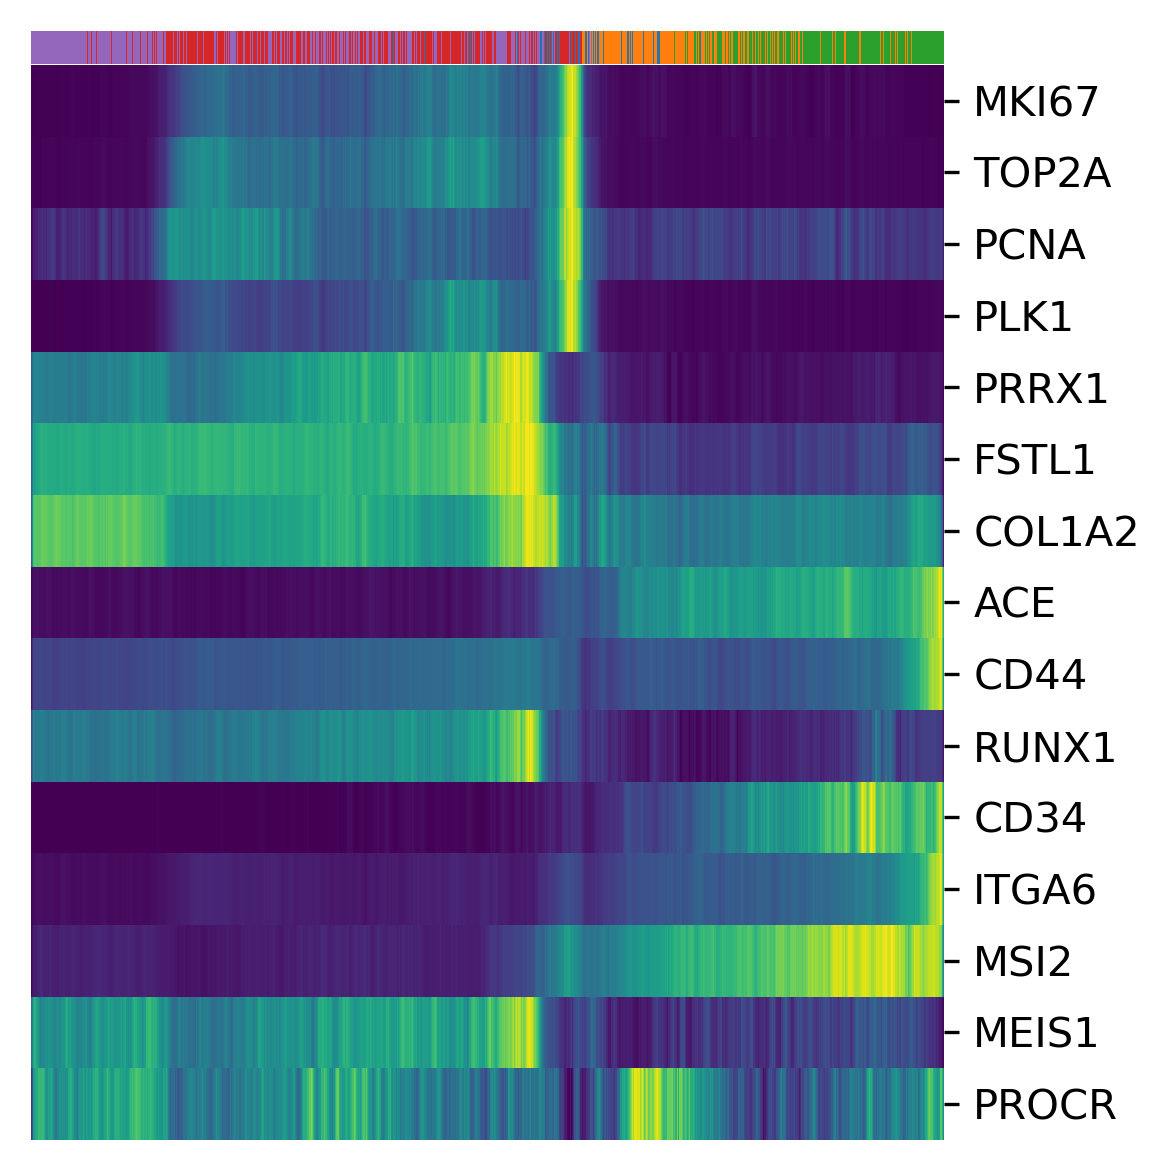

In [48]:
var_names = [
    'MKI67', 'TOP2A', 'PCNA', 'PLK1',
    'PRRX1', 'FSTL1', 'COL1A2', 
    'ACE', 'CD44', 'RUNX1',
    'CD34', 'ITGA6', 'MSI2', 'MEIS1', 'PROCR',
]

var_names = [g for g in var_names if g in adata.var_names]

scv.pl.heatmap(
    adata, 
    var_names=var_names, 
    sortby='mean_velocity_pseudotime', 
    sort=False,
    col_color='cluster_str', 
    figsize=(4, 4),
    yticklabels=True,
    n_convolve=100,
)

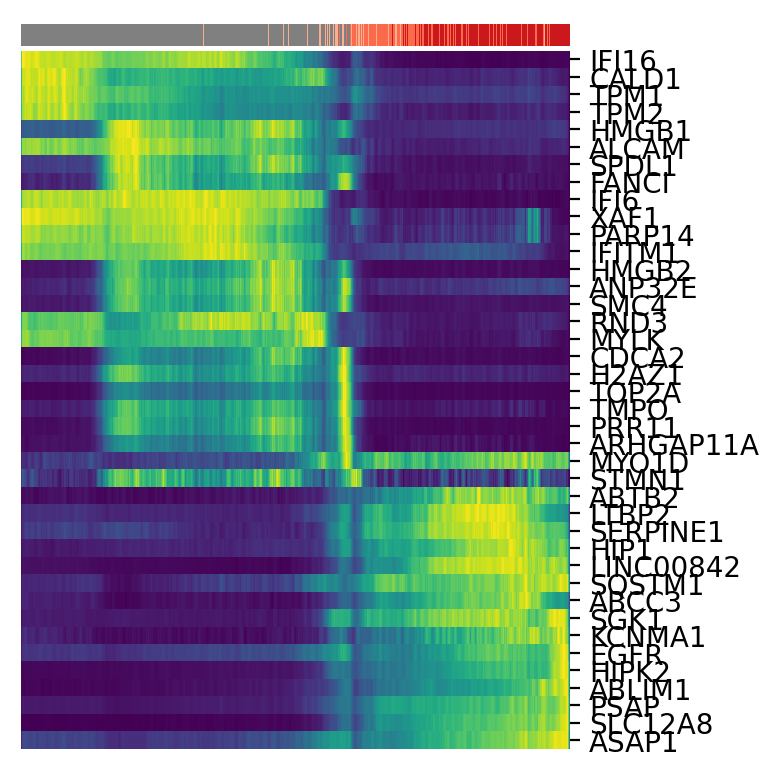

In [17]:
n_genes = 40

df = adata.var.copy()

top_n = df.nlargest(n_genes, 'fit_likelihood')

plt.rcParams['figure.dpi'] = 200

scv.pl.heatmap(
    adata, 
    var_names=top_n.head(n_genes).index, 
    sortby='mean_velocity_pseudotime', 
    col_color='cluster_str', 
    figsize=(4, 4),
    yticklabels=True,
    n_convolve=100,
)

In [16]:
df.sort_values(by='fit_likelihood', ascending=False)[['fit_likelihood']].head(10)

fit_likelihood
LINC00842        0.505075
CALD1            0.490679
TOP2A            0.481517
HMGB1            0.481060
TMPO             0.439042
SMC4             0.427915
SLC12A8          0.418725
HIPK2            0.411275
HIP1             0.396978
HMGB2            0.376369

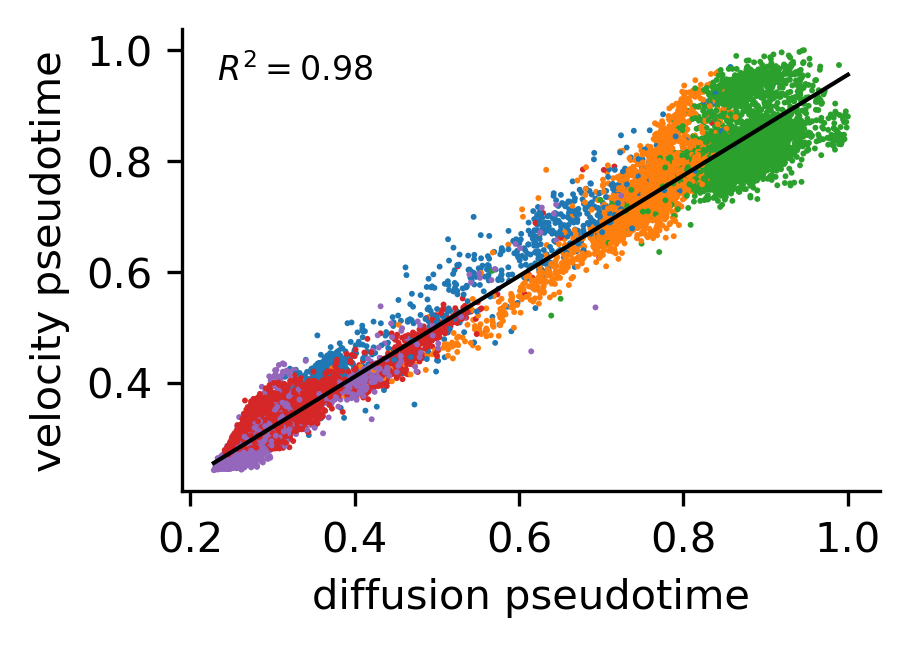

In [5]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 2

sns.scatterplot(
    data=adata.obs,
    x='mean_pseudotime',
    y='mean_velocity_pseudotime',
    hue='cluster_str',
    edgecolor='none',
    s=2,
    legend=False,
    linewidth=0
)

# Fit linear model
x = adata.obs['mean_pseudotime']
y = adata.obs['mean_velocity_pseudotime']
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Plot regression line
x_vals = np.linspace(x.min(), x.max(), 100)
plt.plot(x_vals, intercept + slope * x_vals, color='black', linewidth=1)

# Annotate R²
plt.text(0.05, 0.95, f"$R^2 = {r_value**2:.2f}$", transform=plt.gca().transAxes,
         ha='left', va='top', fontsize=8,
         bbox=dict(facecolor='white', edgecolor='none', alpha=0.8))


# Label axes
plt.xlabel("diffusion pseudotime")
plt.ylabel("velocity pseudotime")

# Remove top and right spines for cleaner visualization
sns.despine()

# Write out

In [13]:
# outpath = "/scratch/indikar_root/indikar1/jrcwycy/hsc_temp/scvelo.h5ad"

# adata.write(outpath)
# adata

AnnData object with n_obs × n_vars = 15867 × 21412
    obs: 'batch', 'phase', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'n_genes', 'n_reads', 'raw_clusters', 'bbknn_clusters', 'harmony_clusters', 'cluster_str', 'barcoded_phase', 'S_score', 'G2M_score', 'dpt_pseudotime', 'dpt_groups', 'dpt_order', 'dpt_order_indices', 'G1_pseudotime', 'G1_order', 'G2M_pseudotime', 'G2M_order', 'mean_pseudotime', 'mean_order', 'nnz', 'velocyto_cell_id', 'cell_id', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'velocity_self_transition', 'velocity_pseudotime', 'G1_velocity_pseudotime', 'G2M_velocity_pseudotime', 'mean_veloci